In [2]:
%matplotlib inline
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [4]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [43]:
train_vec = np.resize(train[:,1:], (train.shape[0], 28*28))
train_vec.shape
test_vec = np.resize(test[:,1:], (test.shape[0], 28*28))
print(train_vec.shape,'\n', test_vec.shape)

(42000, 784) 
 (28000, 784)


## Визуализируем исходные данные

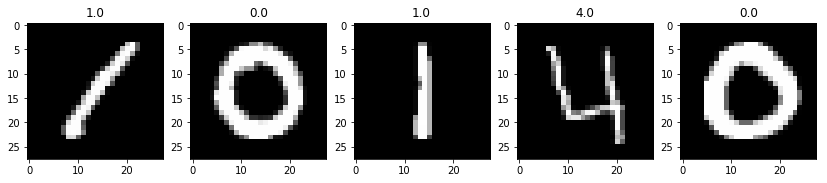

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [7]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

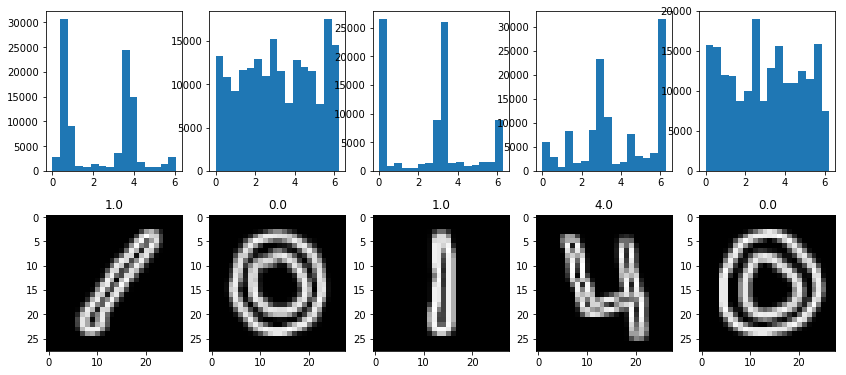

In [8]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [9]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))

for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist
#     train_hist[i] = np.roll(hist, -hist.argmax())

    
    
test_hist = np.zeros((len(test_img), 16))

for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist
#     test_hist[i] = np.roll(hist, -hist.argmax())


## Нормируем вектор гистограммы

In [10]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_vec_norm = scaler.fit_transform(train_vec)
test_vec_norm = scaler.fit_transform(test_vec)

## Разбиваем выборку на обучение и валидацию

In [11]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)

In [49]:
y_train_vec, y_val_vec, x_train_vec, x_val_vec = train_test_split(train_label, train_vec_norm, test_size = 0.2)

## Собираем полносвязную сеть для обучения

In [91]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(32, input_dim=x_train_vec.shape[1], activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Выводим информацию о модели

In [92]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_27 (Dense)             (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


## One hot encoding разметки

In [93]:
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train_vec)

In [94]:
print( y_train_vec.shape, y_train_labels.shape, train_vec_norm.shape)

(33600,) (33600, 10) (42000, 784)


## Запускаем обучение

In [95]:
model.fit(x_train_vec, y_train_labels, batch_size=100, epochs=10)

Epoch 1/10
33600/33600 [==============================] - 2s - loss: 0.5155 - acc: 0.8503     
Epoch 2/10
33600/33600 [==============================] - 1s - loss: 0.2107 - acc: 0.9399     
Epoch 3/10
33600/33600 [==============================] - 1s - loss: 0.1590 - acc: 0.9534     
Epoch 4/10
33600/33600 [==============================] - 1s - loss: 0.1302 - acc: 0.9613     
Epoch 5/10
33600/33600 [==============================] - 1s - loss: 0.1093 - acc: 0.9679     
Epoch 6/10
33600/33600 [==============================] - 1s - loss: 0.0951 - acc: 0.9712     
Epoch 7/10
33600/33600 [==============================] - 1s - loss: 0.0829 - acc: 0.9758     
Epoch 8/10
33600/33600 [==============================] - 1s - loss: 0.0728 - acc: 0.9799     
Epoch 9/10
33600/33600 [==============================] - 1s - loss: 0.0644 - acc: 0.9814     
Epoch 10/10
33600/33600 [==============================] - 1s - loss: 0.0560 - acc: 0.9847     


## Предсказываем класс объекта

In [96]:
pred_val = model.predict_classes(x_val_vec)

8096/8400 [===========================>..] - ETA: 0s

## Оцениваем качество решение на валидационной выборке

In [97]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.102738095238


In [98]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.11      0.12      0.12       816
        1.0       0.10      0.10      0.10       909
        2.0       0.10      0.09      0.10       846
        3.0       0.11      0.10      0.10       937
        4.0       0.10      0.10      0.10       839
        5.0       0.09      0.10      0.09       702
        6.0       0.10      0.11      0.10       785
        7.0       0.10      0.11      0.10       893
        8.0       0.10      0.09      0.10       835
        9.0       0.11      0.11      0.11       838

avg / total       0.10      0.10      0.10      8400



In [99]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[ 99  80  76  89  92  56  88  97  67  72]
 [ 99  93  79 113  82  86 105  89  79  84]
 [ 82 112  80  94  84  79  78  84  82  71]
 [100 124  87  94  78  82  88  96  98  90]
 [ 89  90  90  83  83  72  86  93  68  85]
 [ 70  74  70  62  64  67  65  80  67  83]
 [ 90  84  82  73  78  71  85  79  61  82]
 [ 97 105 102  83  88  79  89  94  78  78]
 [ 82 101  70  84  80  73  73 110  78  84]
 [ 71  87  93  85  80  71  82  93  86  90]]


## Предсказания на тестовыйх данных

In [63]:
pred_test = model.predict_classes(train_vec_norm)

41920/42000 [============================>.] - ETA: 0s

## Визуализируем предсказания

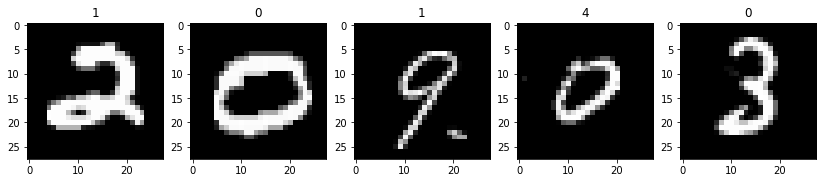

In [64]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [22]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [23]:
# Your submission scored 0.59843